In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/tensorflow-model/Weights/fingerprint.pb
/kaggle/input/tensorflow-model/Weights/saved_model.pb
/kaggle/input/tensorflow-model/Weights/keras_metadata.pb
/kaggle/input/tensorflow-model/Weights/variables/variables.index
/kaggle/input/tensorflow-model/Weights/variables/variables.data-00000-of-00001


In [2]:
#Libraries
!pip install visualkeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import zipfile
import seaborn as sns
import shutil
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,Model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 30.1 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
ziptr = '/kaggle/input/dogs-vs-cats/train.zip'
zipte = '/kaggle/input/dogs-vs-cats/test1.zip'
with zipfile.ZipFile(ziptr,'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile(zipte,'r') as zip_ref:
    zip_ref.extractall()

In [4]:
os.mkdir('validation')
os.mkdir(os.path.join('validation','cats'))
os.mkdir(os.path.join('validation','dogs'))
l=len(os.listdir('train'))
val_size=int(0.2*l)
shuffled_source = random.sample(os.listdir('train'), l)#Randomly shuffle the image
#Transferring the 5000 data to validation in two directories cats and dogs
for each in tqdm(os.listdir('train')[:val_size]):
    name=each.split('.')[0]
    if name=='cat':
        shutil.move(os.path.join('train',each),"validation/cats")
    else :
        shutil.move(os.path.join('train',each),"validation/dogs")
os.mkdir('Train')
os.mkdir(os.path.join('Train','cats'))
os.mkdir(os.path.join('Train','dogs'))
for each in tqdm(os.listdir('train')):
    name=each.split('.')[0]
    if name=='cat':
        shutil.move(os.path.join('train',each),"Train/cats")
    else :
        shutil.move(os.path.join('train',each),"Train/dogs")
shutil.rmtree('train')       

100%|██████████| 20000/20000 [00:00<00:00, 20694.98it/s]


In [5]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

    train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 200,
                                                      class_mode = 'binary',
                                                      target_size = (200,200))
    validation_datagen = ImageDataGenerator(rescale = 1./255.)

    validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 100,
                                                                class_mode = 'binary',
                                                                target_size = (200,200))
    return train_generator, validation_generator

In [6]:
TRAIN_DIR="/kaggle/working/Train"
VAL_DIR="/kaggle/working/validation"
train_generator, validation_generator = train_val_generators(TRAIN_DIR,VAL_DIR)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
(x,y)=next(train_generator)

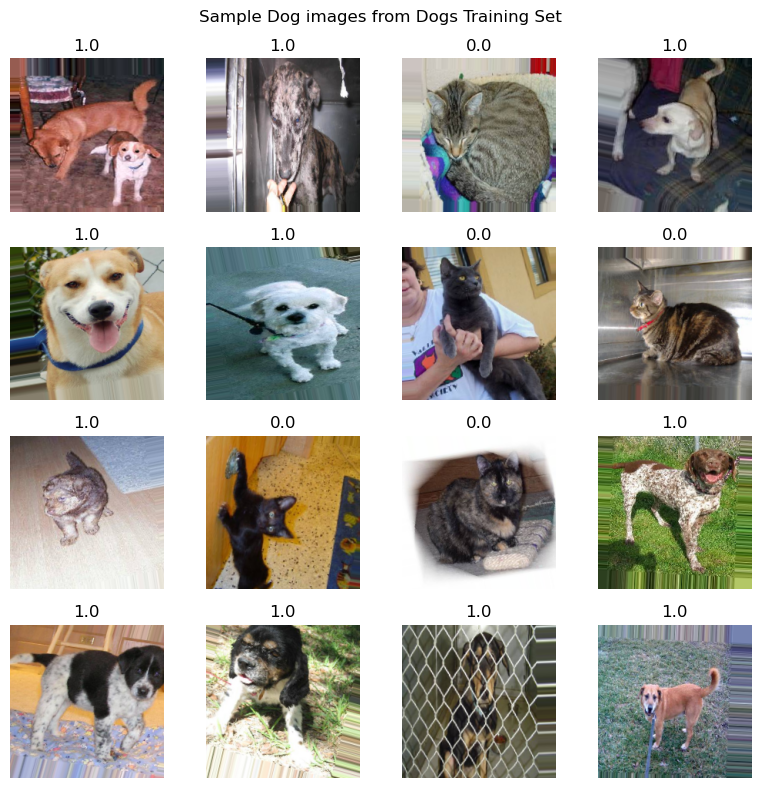

In [8]:
from PIL import Image
fig,axes = plt.subplots(nrows = 4, ncols = 4, figsize = (8,8))
fig.suptitle("Sample Dog images from Dogs Training Set")

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [9]:
pre_trained_model=VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(200,200,3)
    )
for layer in pre_trained_model.layers[:11]:
    layer.trainable = False
pre_trained_model.summary()  

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [10]:
#Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Flatten()(pre_trained_model.get_layer('block5_pool').output)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(pre_trained_model.inputs, x)

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

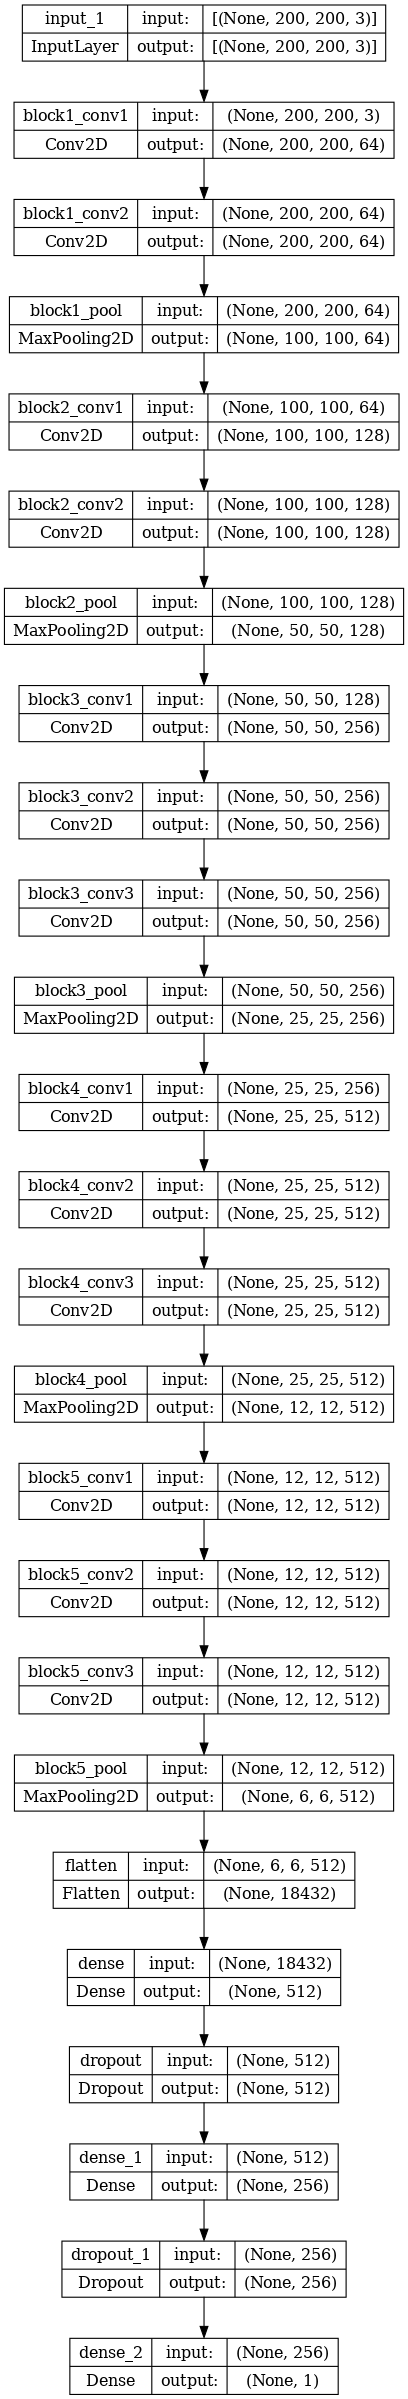

In [11]:
from keras.utils import plot_model
plot_model(model, show_shapes = True,expand_nested = True,dpi = 80)

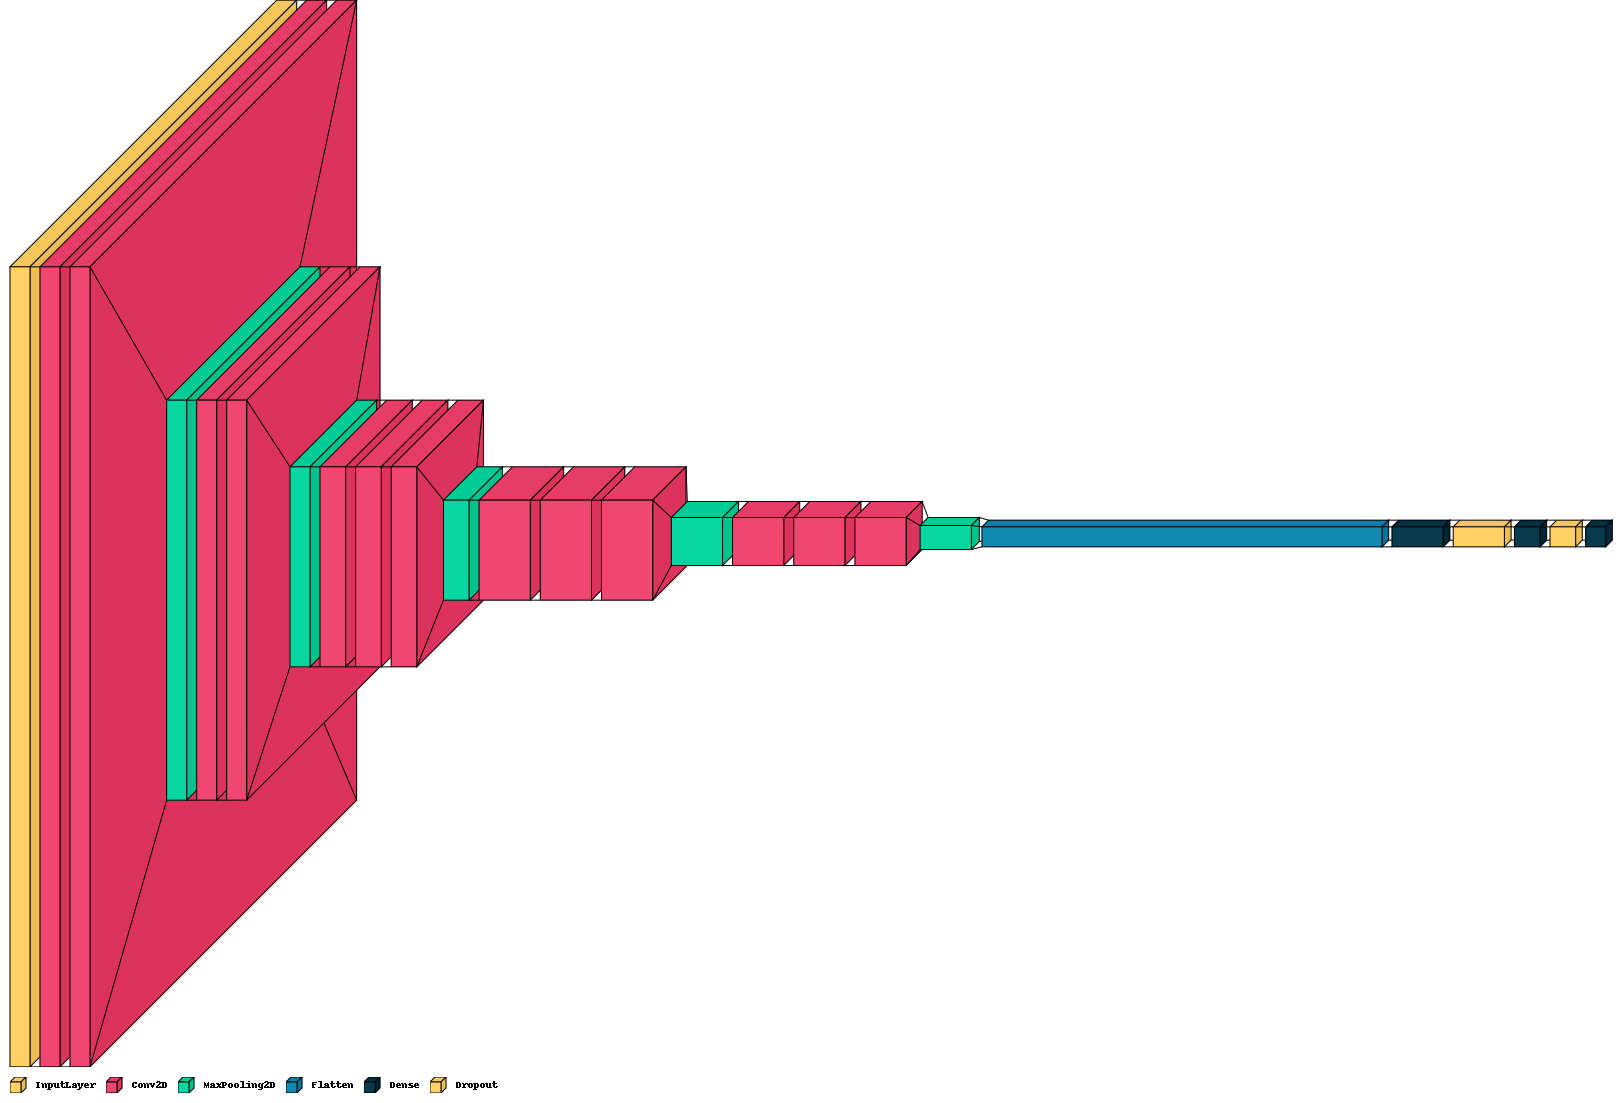

In [12]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

In [13]:
class myCallback(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.999):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.999*100))   
            self.model.stop_training = True
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,verbose=2,callbacks=[myCallback()])

Epoch 1/100
100/100 - 251s - loss: 0.7062 - accuracy: 0.5131 - val_loss: 0.6898 - val_accuracy: 0.5850 - 251s/epoch - 3s/step
Epoch 2/100
100/100 - 226s - loss: 0.4874 - accuracy: 0.7424 - val_loss: 0.1665 - val_accuracy: 0.9340 - 226s/epoch - 2s/step
Epoch 3/100
100/100 - 224s - loss: 0.1840 - accuracy: 0.9273 - val_loss: 0.0891 - val_accuracy: 0.9646 - 224s/epoch - 2s/step
Epoch 4/100
100/100 - 224s - loss: 0.0998 - accuracy: 0.9617 - val_loss: 0.0828 - val_accuracy: 0.9684 - 224s/epoch - 2s/step
Epoch 5/100
100/100 - 225s - loss: 0.0789 - accuracy: 0.9700 - val_loss: 0.0582 - val_accuracy: 0.9776 - 225s/epoch - 2s/step
Epoch 6/100
100/100 - 225s - loss: 0.0733 - accuracy: 0.9722 - val_loss: 0.0603 - val_accuracy: 0.9762 - 225s/epoch - 2s/step
Epoch 7/100
100/100 - 227s - loss: 0.0616 - accuracy: 0.9769 - val_loss: 0.0622 - val_accuracy: 0.9776 - 227s/epoch - 2s/step
Epoch 8/100
100/100 - 236s - loss: 0.0471 - accuracy: 0.9821 - val_loss: 0.0545 - val_accuracy: 0.9824 - 236s/epoch - 

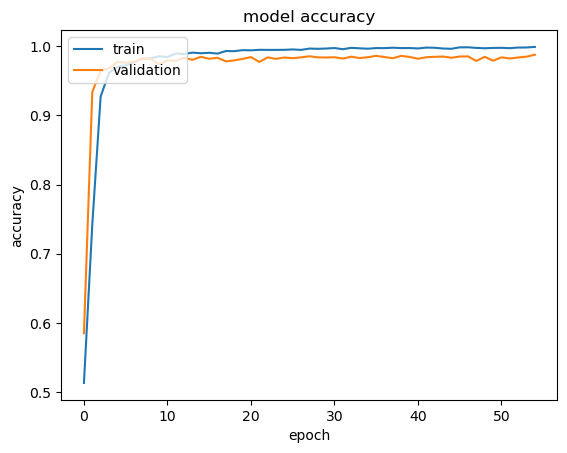

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

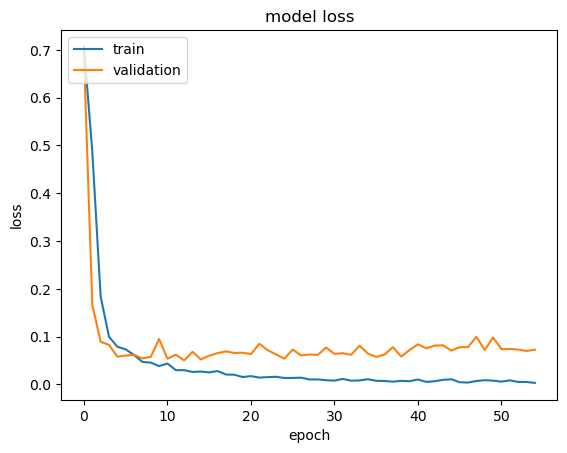

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
#Reloaded Model From Local Drive
from tensorflow.keras.models import load_model
s=load_model('/kaggle/input/tensorflow-model/Weights')

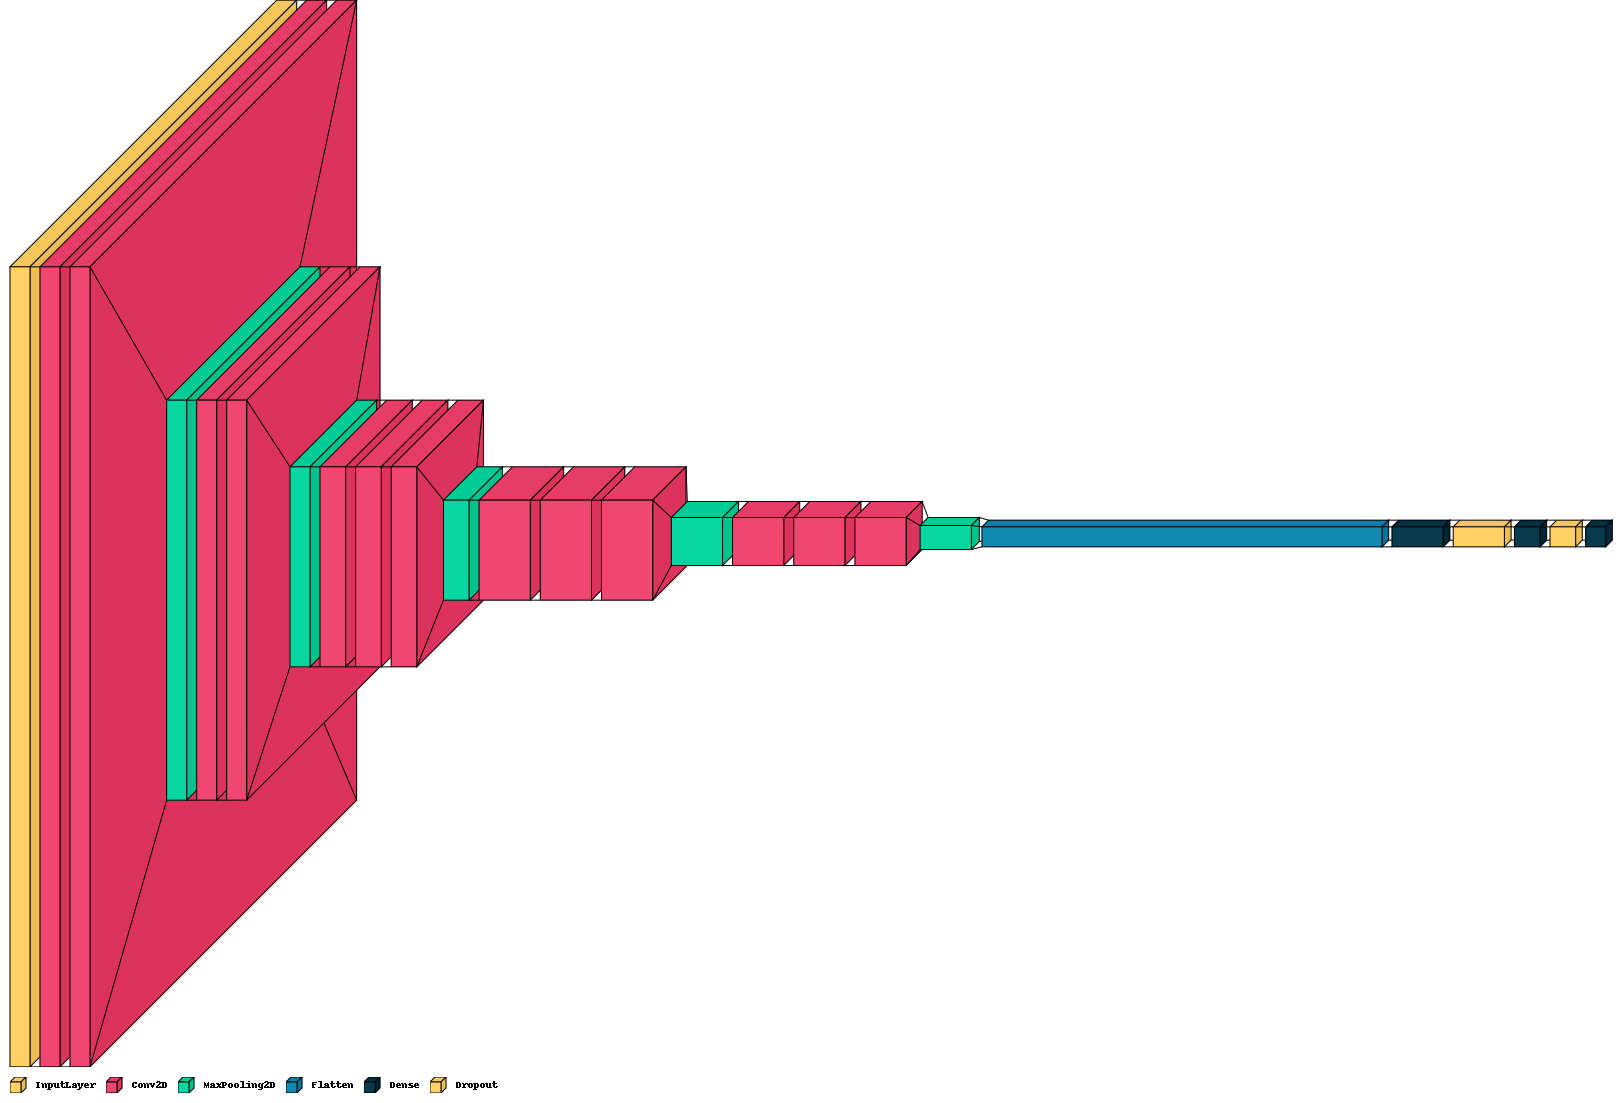

In [17]:
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(s, legend=True) 

In [18]:
s.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [19]:
val_loss,val_accuracy=s.evaluate(validation_generator)
train_loss,train_accuracy=s.evaluate(train_generator)

100/100 [==============================] - 203s 2s/step - loss: 0.0216 - accuracy: 0.9952


In [20]:
print("Validation loss {}".format(val_loss))
print("Validation accuracy {}".format(val_accuracy))
print("Validation loss {}".format(train_loss))
print("Validation accuracy {}".format(train_accuracy))

Validation loss 0.017695270478725433
Validation accuracy 0.996399998664856
Validation loss 0.0216413252055645
Validation accuracy 0.9952499866485596


In [21]:
os.mkdir('test')

In [22]:
shutil.move('test1','test')

'test/test1'

In [23]:
test_gen=ImageDataGenerator(rescale=1./255.)
Length=len(os.listdir('test/test1'))
test_generator=test_gen.flow_from_directory(directory = "test",
                                                      batch_size = 100,
                                                      class_mode = None,
                                                      target_size=(200,200)
                                                      )

Found 12500 images belonging to 1 classes.


In [24]:
test_predicted_label=s.predict(test_generator)

125/125 [==============================] - 33s 266ms/step


In [25]:
train_predicted_label=s.predict(train_generator)

100/100 [==============================] - 204s 2s/step
